In [42]:
# load module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wntr
import wntr_utils
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
import csv
import random

In [3]:
# load STREaM data (STREaM is a simulator of end-uses and water demand patterns)
# This dataset contains 3 years of hourly (26280 data points) synthetic demand data 
# for 4 user_classes = ['low','average','high','morning','night']. There are 500 user for each class,
# with the first 10 users having leaks. We need to remove these users for our purposes. 

all_data_path = './data/allData.txt'
df = pd.read_csv(all_data_path, header=None)

# create headers
user_classes = ['low','average','high','morning','night']
headers = []
for user_class in user_classes:
    suffixes = (('_'+user_class+' ')*400).split() # original
    for suffix, number in zip(suffixes,range(1,401)):
        headers.append('user'+suffix+'_'+'%03d'%number)  
        
# reverse df and change df columns
df = df.T
df.columns = headers

# remove first 10 of each class (these have leaks, so not useful for our purposes)
users_to_remove = np.array(headers).reshape(-1,10)[::40].ravel().tolist()
df.drop(users_to_remove, axis = 1, inplace = True)
headers = df.columns

In [4]:
# this function creates a hourly pattern of multipliers (up to 26280 hours long) mixing together n (max 1950) patterns
# from the STREaM dataset; it scales within a range (as expected for WNTR/EPANET input)
def create_demand_pattern(df_patterns, n_hours=168, n_mix=50, bound = [0.3,0.9], noise_intensity=0.01):
    cols =df_patterns.columns.to_list()
    shuffle(cols)
    df_patterns = df_patterns[cols]
    s = MinMaxScaler(bound)
    temp=np.squeeze(s.fit_transform(df_patterns.iloc[:n_hours,:n_mix].mean(axis=1).values.reshape(-1,1)))
    dem_pat = temp + np.random.randn(n_hours)*noise_intensity
    return dem_pat

In [34]:
# load EPANET model
inp_file = 'ctown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# save original patterns
names, patterns =[],[]
for name, pat in wn.patterns():
    names.append(name)
    patterns.append(pat.multipliers)
df_pat_orig = pd.DataFrame(data = patterns).T
df_pat_orig.columns = names

C:\ProgramData\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning:

Not all curves were used in "ctown_map.inp"; added with type None, units conversion left to user



In [35]:
# Generate a 3-year pattern for the District Metered Area (DMA)
names, patterns =[],[]
for name, pat in wn.patterns():
    names.append(name)
    temp = create_demand_pattern(df, n_hours=24*365*3, n_mix=150)
    pat.multipliers = temp
    patterns.append(pat.multipliers)
df_pat_new = pd.DataFrame(data = patterns).T
df_pat_new.columns = names
df_pat_new.to_csv('three_year_demands_ctown.csv')

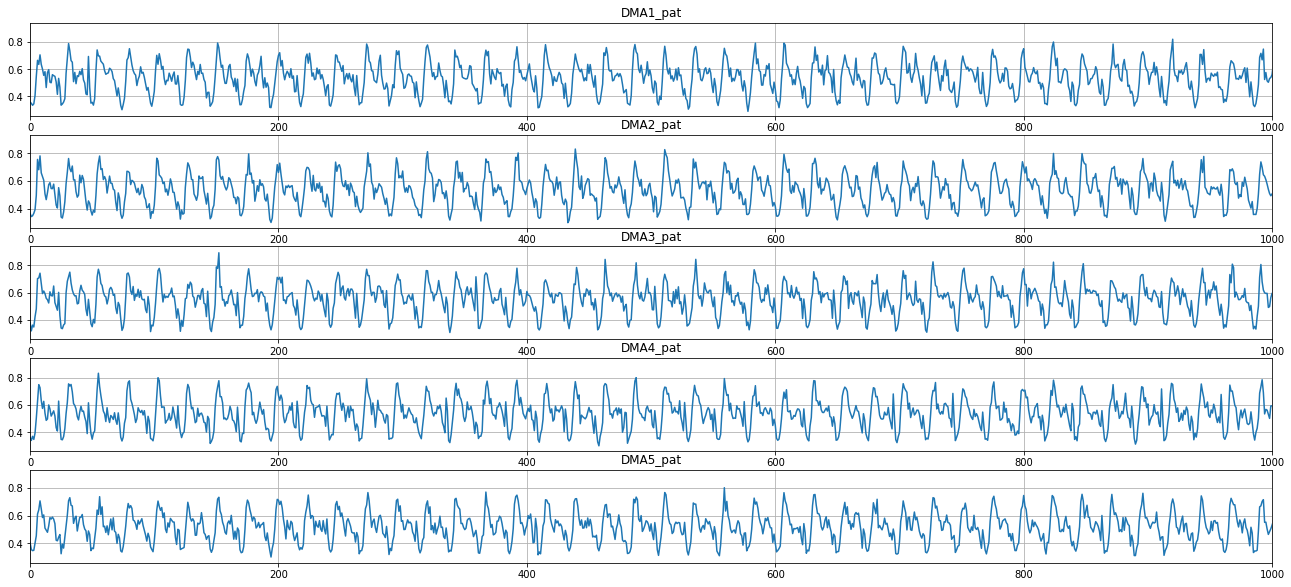

In [36]:
i=1
for pat_name in names:
    dd = plt.subplot(len(names),1,i)
    plt.plot(df_pat_new[pat_name], label="Demand")
    plt.title(pat_name)
    plt.subplots_adjust(top=2.00, right=3.00)
    plt.xlim(left=0, right=1000)
    plt.grid(True)
    i+=1

In [74]:
# Create a pandas dataframe with columns = each DMA pattern and 38 random initial pattern values
values=[]
for j in range(len(names)):
    aux=[]
    for i in range(0,38):
        value = random.randint(0, len(df_pat_new)-168)        
        aux.append(value)
    values.append(aux)
pattern_random_init_point = pd.DataFrame(data = values).T
pattern_random_init_point.columns = names
print(pattern_random_init_point)
pattern_random_init_point.to_csv('starting_demand_points.csv')

In [86]:
# Create a pandas dataframe with initial tank levels for the 7 C-Town tanks and 38 weeks
values=[]
tank_names = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
for name in tank_names:
    aux=[]
    for i in range(0,38):
        tank_max_value = wn.get_node(name).max_level
        min_value = tank_max_value*0.05
        max_value = tank_max_value*0.95
        value = random.uniform(min_value, max_value)        
        aux.append(value)
    values.append(aux)
tank_initial_levels = pd.DataFrame(data = values).T
tank_initial_levels.columns = tank_names
print(tank_initial_levels)
tank_initial_levels.to_csv('tank_initial_conditions.csv')

          T1        T2        T3        T4        T5        T6        T7
0   5.855753  3.106338  6.228892  3.483966  3.837314  0.567281  2.488496
1   0.443767  1.209428  3.054858  4.439615  3.613195  4.135020  0.657265
2   4.298011  3.301477  2.039634  3.685687  0.506580  0.590645  3.515999
3   5.587136  3.865440  5.336564  2.805219  2.740507  2.033552  3.025134
4   0.549132  5.244036  4.892864  1.252343  4.255914  4.686620  2.964372
5   2.243970  1.455748  5.533284  1.980932  1.372740  1.691278  3.362997
6   4.784047  5.460188  4.838881  2.621846  1.599273  3.672341  2.155521
7   5.861904  4.255109  2.088346  1.605590  1.401367  1.290684  0.394047
8   2.613356  2.861203  6.026822  2.430559  1.869935  4.115615  4.501025
9   4.570292  3.682639  2.463327  3.886210  1.237081  4.662103  3.100654
10  5.235941  2.426839  5.658630  3.848887  3.973598  1.808122  1.400775
11  2.969231  3.028356  5.580505  4.090204  0.405793  4.649611  4.029787
12  1.812664  5.106394  4.385510  1.943169  2.77144